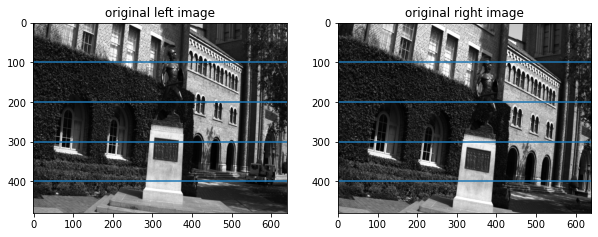


 num of keypoints kp1 = 1289

 num of keypoints kp2 = 1252

 number of good matches = 735

 number of pts1 = 735

 number of pts2 = 735

 number of element of mask = 735

 fundamental matrix:
[[   0.000    0.000   -0.050]
 [  -0.000    0.000    0.089]
 [   0.044   -0.091    1.000]]

 number of pts1 = 576

 number of pts2 = 576

 shape of pts2 = (576, 2)

 shape of lines1 = (576, 1, 3)

 shape of lines1 = (576, 3)


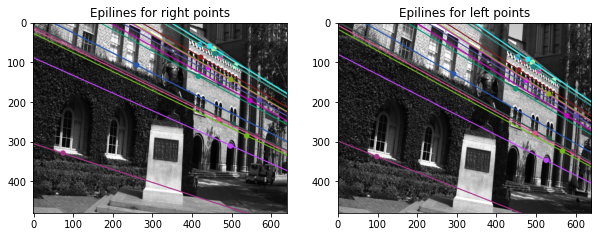


 
 homography1 :
[[   0.077    0.035    2.712]
 [  -0.055    0.087   21.988]
 [  -0.000   -0.000    0.125]]

 
 homography2 :
[[   0.729    0.373   -2.561]
 [  -0.577    0.828  225.696]
 [  -0.001   -0.000    1.224]]

 data type of dst11 = uint8


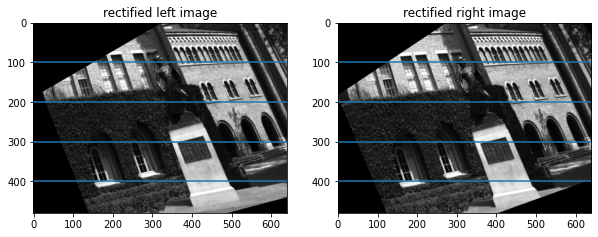

(-1, None)

In [1]:
# 예제 10.3-1 프로그램
##  ok

import cv2
import matplotlib.pyplot as plt
import numpy as np

################## define function that visualize epilines
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    
    r, c = img1src.shape
    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    
    # use the same random seed for random color 
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        
        # 직선 방정식 r[0]x + r[1]y + r[2] =0 에서 
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 2)
        img1color = cv2.circle(img1color, tuple(pt1), 7, color, -1)
        img2color = cv2.circle(img2color, tuple(pt2), 7, color, -1)
        
    return img1color, img2color
###################

dst1 = cv2.imread('../../data/TOMMY2_L.png', 0)
dst2 = cv2.imread('../../data/TOMMY2_R.png', 0)

dst1 = cv2.resize(dst1, dsize=(640,480), interpolation=cv2.INTER_AREA)
dst2 = cv2.resize(dst2, dsize=(640,480), interpolation=cv2.INTER_AREA)

# Draw the original images with horizontal lines
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(dst1,cmap="gray"),axes[0].set_title("original left image") 
axes[1].imshow(dst2,cmap="gray"),axes[1].set_title("original right image")
axes[0].axhline(100), axes[1].axhline(100), axes[0].axhline(200), axes[1].axhline(200)
axes[0].axhline(300), axes[1].axhline(300), axes[0].axhline(400), axes[1].axhline(400)
plt.show()

img_size = dst1.shape[::-1] # img_size 높이와 폭 값 교환

# 실수 출력 포맷 셋팅
float_formatter = "{:8.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Obtain correspondent points with SIFT
sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.09)
kp1, des1 = sift.detectAndCompute(dst1,None)
kp2, des2 = sift.detectAndCompute(dst2,None)
print('\n num of keypoints kp1 =', len(kp1))
print('\n num of keypoints kp2 =', len(kp2))

### FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

# flann 매처 생성 및 가장 가까운 매칭점 2개씩 검색하여 리스트로 반환
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = [] 
pts1 = []
pts2 = []

### ratio test 
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
print('\n number of good matches =', len(good))

# 거리값을 기준으로 정렬
sorted_good = sorted(good, key = lambda x : x.distance)        
for m in sorted_good :
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)
       
pts1 = np.array(pts1) # np 배열로 변환, float64 타입
pts2 = np.array(pts2)
print('\n number of pts1 =', len(pts1))
print('\n number of pts2 =', len(pts2))
# get fundamental matrix
F,mask= cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
print('\n number of element of mask =', len(mask))
print('\n fundamental matrix:')
print(F)

# 인-라이어만 선택 및 데이터형 변환
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

print('\n number of pts1 =', len(pts1))
print('\n number of pts2 =', len(pts2))
print('\n shape of pts2 =', pts2.shape)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# 키포인들에 대한 epipolalines를 상대영상에서 검출 및 출력  
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)

print('\n shape of lines1 =', lines1.shape)
lines1 = lines1.reshape(-1, 3)
print('\n shape of lines1 =', lines1.shape)

img5, img6 = drawlines(dst1, dst2, lines1[:25], pts1, pts2)

lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(dst2, dst1, lines2[:25], pts2, pts1)

plt.figure(figsize =(10,5))
plt.subplot(121), plt.imshow(img5), plt.title("Epilines for right points")
plt.subplot(122), plt.imshow(img3), plt.title("Epilines for left points")
plt.show()

# get homography from fundamental matrix
p1fNew = pts1.reshape((pts1.shape[0] * 2, 1))
p2fNew = pts2.reshape((pts2.shape[0] * 2, 1))

retB,rectM1,rectM2 = cv2.stereoRectifyUncalibrated(p1fNew,p2fNew,
                                                   F,img_size,3)
print('\n \n homography1 :')
print(rectM1)

print('\n \n homography2 :')
print(rectM2)

# transform with homography
dst11 = cv2.warpPerspective(dst1,rectM1,img_size)
dst22 = cv2.warpPerspective(dst2,rectM2,img_size)
print('\n data type of dst11 =', dst11.dtype)

# store rectified images
cv2.imwrite("rectified_1.png", dst11)
cv2.imwrite("rectified_2.png", dst22)

# Draw the rectified images with horizontal lines
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(dst11,cmap="gray"),axes[0].set_title("rectified left image") 
axes[1].imshow(dst22,cmap="gray"),axes[1].set_title("rectified right image")
axes[0].axhline(100), axes[1].axhline(100), axes[0].axhline(200), axes[1].axhline(200)
axes[0].axhline(300), axes[1].axhline(300), axes[0].axhline(400), axes[1].axhline(400)
plt.show()

cv2.waitKey(), cv2.destroyAllWindows()
